In [28]:
import numpy as np
from scipy.optimize import minimize
import librosa as lb
import soundfile as sf
from tqdm import tqdm
import museval

In [29]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [30]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [31]:
def objective(params, X, m, gamma1, gamma2):
    n, l = X.shape
    A = params[:n**2].reshape((n, n))
    S = params[n**2:].reshape((n, l))
    t = np.sum(S, axis=0)
    return np.linalg.norm(X - np.dot(A, S))**2 + np.linalg.norm(m - t)**2


def minimize_function(X, m, gamma1, gamma2):

    n, l = X.shape
    A_init = np.eye(n)
    S_init = X.copy()
    
    '''
    A_init = np.array([[0.82, 0.02, 0.09, 0.016],
                  [0.021, 0.71, 0.15, 0.16],
                  [0.1, 0.12, 0.9, 0.16],
                  [0.09, 0.2, 0.15, 0.7]])
    '''

    # set bounds for A and S separately
    A_bounds = [(0.7, 1) if i == j else (gamma1, gamma2) for i in range(n) for j in range(n)]
    S_bounds = [(-np.inf, np.inf)] * (n * l)
    bounds = A_bounds + S_bounds

    # alternating optimization
    params = np.concatenate([A_init.ravel(), S_init.ravel()])
    res = minimize(objective, params, args=(X, m, gamma1, gamma2), method='L-BFGS-B', bounds=bounds)

    # extract the optimized A and S
    A_opt = res.x[:n**2].reshape((n, n))
    S_opt = res.x[n**2:].reshape((n, l))
    
    return A_opt, S_opt

In [32]:
clean_path = "/home/rajesh/Desktop/Test1/"
outpath = "/home/rajesh/Desktop/Test1/"

In [33]:
vocals, fs = lb.load(clean_path+'tvocal.wav')
bass, fs = lb.load(clean_path+'tbass.wav')
drums, fs = lb.load(clean_path+'tdrums.wav')
other, fs = lb.load(clean_path+'tothers.wav')

bvocals = 0.91 * vocals + 0.02 * bass + 0.21 * drums + 0.17 * other
bbass = 0.091 * vocals + 0.82 * bass + 0.13 * drums + 0.07 * other
bdrums = 0.1 * vocals + 0.09 * bass + 1 * drums + 0.17 * other
bother = 0.21 * vocals + 0.02 * bass + 0.1 * drums + 0.72 * other

mixture = vocals + bass + drums + other

X = np.array([bvocals, bbass, bdrums, bother])
S = np.array([vocals, bass, drums, other])
m = np.array([mixture]) #NOTE HERE

O = np.array([np.ones(4)]).T

block = 25
A_pred, S_pred = [], []

for i in tqdm(range(0, X.shape[1], block)):
    x_ = X[:, i:i+block]
    m_ = m[:, i:i+block]
    A_opt, S_opt = minimize_function(x_, m_, 0.001, 1)
    S_pred.append(S_opt)
    A_pred.append(A_opt)

S_pred = np.hstack(S_pred)

sf.write(outpath+'pred_vocal.wav', S_pred[0], fs)
sf.write(outpath+'pred_bass.wav', S_pred[1], fs)
sf.write(outpath+'pred_drums.wav', S_pred[2], fs)
sf.write(outpath+'pred_others.wav', S_pred[3], fs)

tv_sdr = compute_sdr(vocals, bvocals, fs)
tb_sdr = compute_sdr(bass, bbass, fs)
td_sdr = compute_sdr(drums, bdrums, fs)
to_sdr = compute_sdr(other, bother, fs)

true_sdr = (tv_sdr + tb_sdr + td_sdr + to_sdr)/4
print(true_sdr, tv_sdr, tb_sdr, td_sdr, to_sdr)

v_sdr = compute_sdr(vocals, S_pred[0], fs)
b_sdr = compute_sdr(bass, S_pred[1], fs)
d_sdr = compute_sdr(drums, S_pred[2], fs)
o_sdr = compute_sdr(other, S_pred[3], fs)

obtained_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
print(obtained_sdr, v_sdr, b_sdr, d_sdr, o_sdr)

A_avg = np.average(A_pred, axis=0)
print(np.round(A_avg, 3))

A_act = X @ np.linalg.pinv(S)
print(np.round(A_act, 4))
print(np.round(np.linalg.norm(A_act - A_avg)**2, 4))

100%|███████████████████████████████████████████████████████████████████████████| 8820/8820 [27:50<00:00,  5.28it/s]


9.02507507004891 8.265484028848913 14.634972932254602 2.363512577148436 10.83633074194369
11.81681966199978 12.5253162498704 18.28543860251801 4.760505144633225 11.69601865097749
[[0.994 0.012 0.083 0.052]
 [0.074 0.928 0.099 0.049]
 [0.071 0.012 0.998 0.051]
 [0.069 0.012 0.086 0.973]]
[[0.91  0.02  0.21  0.17 ]
 [0.091 0.82  0.13  0.07 ]
 [0.1   0.09  1.    0.17 ]
 [0.21  0.02  0.1   0.72 ]]
0.1555


In [34]:
A_pred

[array([[0.99999999, 0.001     , 0.001     , 0.001     ],
        [0.001     , 0.99999999, 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.99999999, 0.001     ],
        [0.001     , 0.001     , 0.001     , 1.        ]]),
 array([[1.        , 0.00100108, 0.00100059, 0.00100051],
        [0.00100044, 1.        , 0.0010006 , 0.00100051],
        [0.00100044, 0.00100108, 1.        , 0.00100051],
        [0.00100044, 0.00100108, 0.00100059, 1.        ]]),
 array([[1.   , 0.001, 0.001, 0.001],
        [0.001, 1.   , 0.001, 0.001],
        [0.001, 0.001, 1.   , 0.001],
        [0.001, 0.001, 0.001, 1.   ]]),
 array([[1.   , 0.001, 0.001, 0.001],
        [0.001, 1.   , 0.001, 0.001],
        [0.001, 0.001, 1.   , 0.001],
        [0.001, 0.001, 0.001, 1.   ]]),
 array([[0.99999999, 0.001     , 0.001     , 0.001     ],
        [0.001     , 1.        , 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.99999999, 0.001     ],
        [0.001     , 0.001     , 0.001     , 0.999

In [36]:
import pandas as pd

In [35]:
csv_path = "/home/rajesh/Desktop/sdr.csv"

In [40]:
sdr = pd.read_csv(csv_path)
sdr.head()

,Unnamed: 0,vocal sdr,bass sdr,drums sdr,other sdr,Overall sdr,vocal isr,bass isr,drums isr,other isr,...,Pred bass sir,Pred drums sir,Pred other sir,Pred Overall sir,Pred vocal sar,Pred bass sar,Pred drums sar,Pred other sar,Pred Overall sar,Closeness
0,0.0,9.628191,8.496787,7.848714,5.207421,7.795278,15.259218,14.790870,8.501634,20.404180,...,inf,inf,inf,inf,54.196583,9.661798,32.619321,16.726728,28.301108,0.019820
1,1.0,6.568760,11.061088,7.260420,4.248227,7.284624,15.321890,15.681455,8.654047,28.228128,...,inf,inf,inf,inf,50.913585,15.450291,35.698783,21.826192,30.972213,0.019768
2,2.0,8.016602,12.053449,7.509245,6.456254,8.508888,15.384289,15.591541,8.194212,24.095160,...,inf,inf,inf,inf,46.084516,15.853876,33.204227,23.293093,29.608928,0.019784
3,3.0,8.517713,7.672911,8.769153,8.198101,8.289469,11.368062,13.582775,17.014250,10.146383,...,inf,inf,inf,inf,44.788479,10.800581,32.917701,32.331213,30.209494,0.022634
4,4.0,-0.651605,7.954021,8.877697,9.241523,6.355409,10.934381,13.836196,17.306435,10.169657,...,inf,inf,inf,inf,37.411430,42.602497,43.708300,56.136851,44.964770,0.022553


In [66]:
import seaborn as sns

In [71]:
sdrs = [sdr['Overall sdr'], sdr['Pred Overall sdr']]

[]

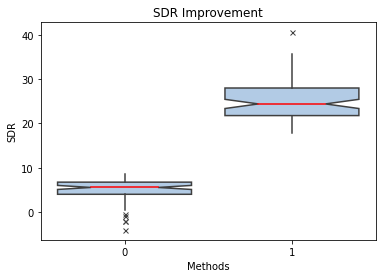

In [98]:
ax = sns.boxplot(
    data=sdrs,
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "red"},
)
ax.set(xlabel='Methods', ylabel='SDR', title='SDR Improvement')
ax.plot()

In [105]:
Mysdr = pd.read_csv('/home/rajesh/Downloads/ResultsMyCodeKAMIR.csv')

In [110]:
Mysdr.head()

,Name,"SDR(T, P)",Time Taken (s),||A - Apred||^2,Unnamed: 4,"SDR(T, P).1",Time Taken (s).1,||A - Apred||^2.1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Music Delta - Hendrix,50.46,8.0,0.000364,NaN,11.940,6.53,0.131571
2,Dark Ride - Burning Bridges,55.23,8.0,0.000094,NaN,7.740,6.93,0.210300
3,Flags - 54,37.82,7.0,0.001673,NaN,11.244,7.92,0.149604
4,Invisible Familiars - Disturbing Wildlife,33.98,7.0,0.020167,NaN,12.250,6.90,0.125345


In [113]:
mycode = Mysdr['SDR(T, P)']
kamir = Mysdr['SDR(T, P).1']

In [118]:
mycode = mycode.dropna()
kamir = kamir.dropna()

In [143]:
comp = [sdr['Overall sdr'][:12], sdr['Pred Overall sdr'][:12], mycode, kamir, dca]

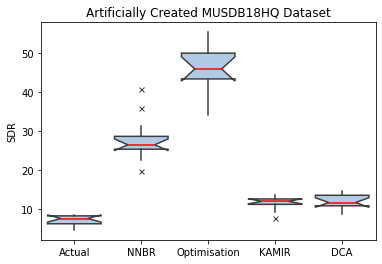

In [145]:
ax = sns.boxplot(
    data=comp,
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "red"},
)
ax.set(xlabel='', ylabel='SDR', title='Artificially Created MUSDB18HQ Dataset')
ax.set_xticklabels(['Actual', 'NNBR', 'Optimisation', 'KAMIR', 'DCA'])
#plt.xticks(rotation=0, ha='right')
plt.show()

In [141]:
def random():
    return np.random.uniform(8, 15)

In [142]:
dca = []
for i in range(12):
    dca.append(random())